In [ ]:
# Install necessary packages
# !pip install pandas numpy scikit-learn nltk matplotlib seaborn

import pandas as pd

# Load the data
data = pd.read_csv("worldnews_data_4770_19:55:2.csv")

# View the first few rows of the data
print(data.head())

import re
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')

# Function to clean text data
def clean_text(text):
    text = re.sub(r'\W+', ' ', text)  # Remove non-alphanumeric characters
    text = text.lower()  # Convert to lowercase
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])  # Remove stopwords
    return text

# Replace NaN values in 'Text' with the corresponding 'Title'
data['Text'] = data.apply(lambda row: row['Title'] if pd.isna(row['Text']) else row['Text'], axis=1)

# Process missing values
data.fillna({'Title': 'Unknown', 'Text': 'Unknown', 'Author': 'Unknown'}, inplace=True)
data.dropna(subset=['Upvotes', 'Number of Comments', 'Timestamp'], inplace=True)

# Change 'Number of Comments' values that are 'Comment' to 0
data['Number of Comments'] = data['Number of Comments'].replace('Comment', 0)

# Ensure 'Number of Comments' column is of integer data type
data['Number of Comments'] = data['Number of Comments'].astype(int)

# timestamp process
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# Clean 'Title' and 'Text' columns
data['Cleaned_Title'] = data['Title'].apply(clean_text)
data['Cleaned_Text'] = data['Text'].apply(clean_text)
# print(data[['Cleaned_Title', 'Cleaned_Text']].head())

                                               Title  \
0  Exposed: How Hamas steals fuel from Gaza's hos...   
1                                            Comment   
2                                            Comment   
3                                            Comment   
4                                            Comment   

                                                Text            Timestamp  \
0                                                NaN  2023-11-01T15:33:37   
1  When the entirety of infrastructure in Gaza, h...  2023-11-01T15:38:45   
2            No, silly, Israelis are the monsters...  2023-11-01T15:46:02   
3  People truly do not understand how sick Hamas ...  2023-11-01T15:45:27   
4                              Oh shit wrong sub huh  2023-11-01T15:46:43   

            Author  Upvotes Number of Comments  \
0    everybodydumb       20                  5   
1     Hk-Neowizard        1            Comment   
2  StrangerFew2424        1            Comment   


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zs_jin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import pandas as pd

# Basic statistical information
print("Basic Statistical Information:")
print(data.describe())

# Statistics for numerical data
print("\nStatistics for Upvotes:")
print(data['Upvotes'].describe())

print("\nStatistics for Number of Comments:")
print(data['Number of Comments'].describe())

# Frequency statistics for categorical data
print("\nAuthor Posting Frequency:")
print(data['Author'].value_counts())

# Check for missing values
print("\nMissing Values Statistics:")
print(data.isnull().sum())


Basic Statistical Information:
            Upvotes  Number of Comments
count   4770.000000         4770.000000
mean      24.407338            1.331866
std      307.037543           73.494593
min      -90.000000            0.000000
25%        1.000000            0.000000
50%        1.000000            0.000000
75%        5.000000            0.000000
max    16442.000000         5057.000000

Statistics for Upvotes:
count     4770.000000
mean        24.407338
std        307.037543
min        -90.000000
25%          1.000000
50%          1.000000
75%          5.000000
max      16442.000000
Name: Upvotes, dtype: float64

Statistics for Number of Comments:
count    4770.000000
mean        1.331866
std        73.494593
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      5057.000000
Name: Number of Comments, dtype: float64

Author Posting Frequency:
Unknown             96
saarlv44            36
Goldreaver          28
Stormayqt           28
Eldanon       

In [ ]:
# featuring


from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000) 

title_bow = vectorizer.fit_transform(data['Cleaned_Title'])
text_bow = vectorizer.fit_transform(data['Cleaned_Text'])

print(title_bow.shape, text_bow.shape)

(4770, 401) (4770, 1000)


In [ ]:
#!pip install textblob
from textblob import TextBlob

data['Sentiment'] = data['Cleaned_Text'].apply(lambda x: TextBlob(x).sentiment.polarity)


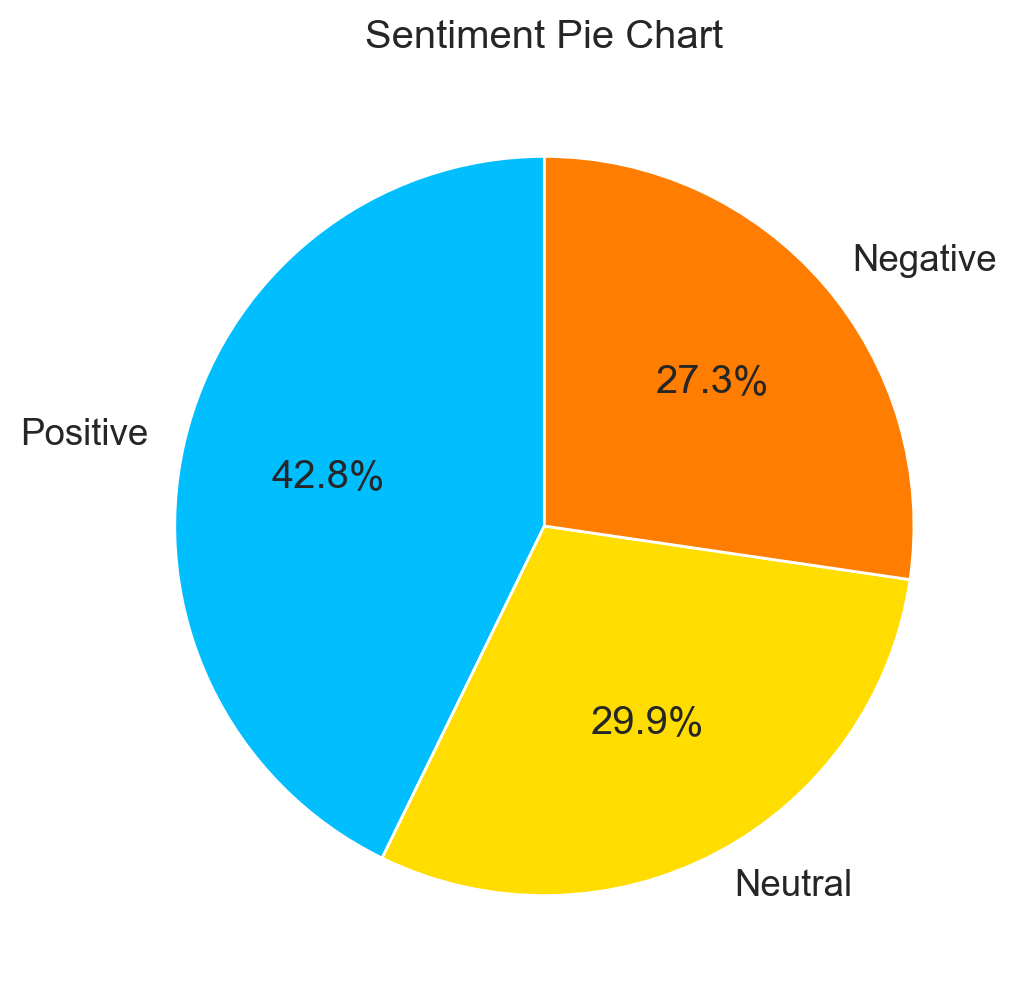

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

data['Sentiment_Label'] = data['Sentiment'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

sentiment_counts = data['Sentiment_Label'].value_counts()
plt.figure(figsize=(8, 6))
sentiment_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Pie Chart')
plt.ylabel('')
plt.show()


## Training a model to identify the political stance using XLNet

### Necessary imports

In [ ]:
# !pip install transformers
# !pip install -q -U watermark
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

import transformers
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from pylab import rcParams

from torch import nn, optim
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.12.0

numpy       : 1.24.3
pandas      : 1.5.3
torch       : 2.0.1
transformers: 4.29.2



device(type='cpu')

### Stance matching

Applying LDA to label the examples and select the ones that are on the Palestine Israel conflict.
Please note that since we are utilizing the post-comment structure, we have to adjust the dataframe first.

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# adjust the data frame so that the title of comments would be the titles of the posts to which they belong

current_post_title = None

for index, row in data.iterrows():
    if row['Cleaned_Title'] != 'comment':
        current_post_title = row['Cleaned_Title']
    else:
        data.at[index, 'Cleaned_Title'] = current_post_title

#Applying LDA

vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5,
                                min_df = 10)
vectorized_titles = vectorizer.fit_transform(data['Cleaned_Title'])

n_topics = 15

lda = LatentDirichletAllocation(n_components=n_topics)  # Number of topics
lda.fit(vectorized_titles)

doc_topic = lda.transform(vectorized_titles)
topic_labels = doc_topic.argmax(axis=1)
data['topic'] = topic_labels

# Display LDA results and select the related texts

n_top_words = 8

def get_related_topic_indices(model, feature_names, n_top_words):
    related_topics=[]
    keywords= ['palestine', 'palestinian', 'gaza', 'israel', 'israeli', 'zionist', 'idf', 'hamas']
    for topic_idx, topic in enumerate(model.components_):
        top_words = " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(f"Topic {topic_idx}:")
        print(top_words)
        if any(keyword in top_words for keyword in keywords):
            related_topics.append(int(topic_idx))
    return related_topics

related_topics = get_related_topic_indices(lda, vectorizer.get_feature_names_out(), n_top_words)
print(related_topics)
relevant_data = data[data['topic'].isin(related_topics)]
print(relevant_data.head())

# LDA visualization
"""
import matplotlib.pyplot as plt

def plot_top_words(model, feature_names, no_top_words, title):
    fig, axes = plt.subplots(1, n_topics, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-no_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx + 1}', fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda, feature_names, no_top_words, 'Topics in LDA model')
"""

# !pip install pandas nltk gensim
from gensim.corpora import Dictionary

# create dictionary
titles = data['Cleaned_Title'].to_list()
titles = list(set(titles))

from nltk.tokenize import word_tokenize
def tokenize_lowercase_stopword(tweets):
    res = []
    for tweet in tweets:
        tmp = [word for word in word_tokenize(tweet)]
        res.append(tmp)
    return res

titles = tokenize_lowercase_stopword(titles)

text_dict = Dictionary(titles)
# generate bag-of-word format data
title_bow_2 = [text_dict.doc2bow(title) for title in titles]

# !pip install pyLDAvis
from gensim.models.ldamodel import LdaModel
lda_2 = LdaModel(corpus=title_bow_2,num_topics=n_topics, id2word = text_dict, passes=10,random_state=None)

"""
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_2, title_bow_2, lda_2.id2word)
vis
"""

Topic 0:
gaza american killed relatives day single family mourns
Topic 1:
president deal offer putin ramaswamy spoke war russia
Topic 2:
group gaza hideout video terrorists hospital confirm interrogation
Topic 3:
korea says russia south artillery shells shipped north
Topic 4:
humanitarian selectively carte law applied int menu gaza
Topic 5:
bolivia recall ambassadors dipolmatic ties severs colombia chile
Topic 6:
gps russia ukraine guided bomb set hit jammer
Topic 7:
war reports accuses media crimes freedom deaths journalists
Topic 8:
global leaders warn cause harm catastrophic tanzania german
Topic 9:
idf hospitals gazan releases proof stealing gas tel
Topic 10:
faces iran russia war worldnews crisis live thread
Topic 11:
israeli government sex legislation fallen partners advances soldiers
Topic 12:
thread worldnews live crisis russia iran war exit
Topic 13:
ukraine refugees killed reports russia iran war worldnews
Topic 14:
lgbtq images hungary exhibition bans teens display iran
[0, 

'\nimport pyLDAvis\nimport pyLDAvis.gensim_models\npyLDAvis.enable_notebook()\nvis = pyLDAvis.gensim_models.prepare(lda_2, title_bow_2, lda_2.id2word)\nvis\n'

Now that we've got the relevant data, we're going to do the sentiment analysis.
However, since we don't have enough manually labeled data to train a transformer to classify whether a text is "pro-Palestine", "pro-Israel", or "Neutral", we have to make a roundabout.

To get the general sentiment for the two sides on this sub, we can just train a model to evaluate whether the incident described in the title is something that is in favor of either side, and then doing sentiment analysis on comments, to get the stance of one post. The rasionale behind this is that, in normal sentiment analysis, the information in the post-comment-comment structure is not fully utilized. In our case, if one event is beneficial for Israel, then the negtive response of the commonts would signal a general stance for Palestine, which is very intuitive.

To achieve this, we need manually label event-favored_side pairs. Then we use the data to fine-tune a XLNet to classify all titles. Once we classified all the titles in our data base, we then use vadersentiment to get the sentiment of each comment and weight the sentiment on it's upvote and adding them together to get a general stance for a post. By collecting all the stances of posts we can see the general sentiments towrads both sides of the conflict in this huge subreddit.

# preliminary results

Implementing the SVM we trained on the cleaned data

In [ ]:
#Natural Language Processing: Sentiment Analysis with SVM

# generate "ground truth"
# !pip install vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

def assign_sentiment(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

analyzer = SentimentIntensityAnalyzer()
data['Sentiment_Label'] = data['Cleaned_Text'].apply(lambda x: assign_sentiment(analyzer.polarity_scores(x)['compound']))


# Training on the whole corpus

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(data['Cleaned_Text'], data['Sentiment_Label'], test_size=0.2)

# Vectorization
vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5,
                                min_df = 10)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# SVM Classifier
svm = SVC(kernel='linear')
svm.fit(X_train_tfidf, y_train)

# Predictions and Evaluation
y_pred = svm.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

# applying the cleaned corpus to the SVM

analyzer = SentimentIntensityAnalyzer()
relevant_data['Sentiment_Label'] = relevant_data['Cleaned_Text'].apply(lambda x: assign_sentiment(analyzer.polarity_scores(x)['compound']))

# X_, X_toss, y_, y_toss = train_test_split(relevant_data['Cleaned_Text'], relevant_data['Sentiment'], test_size=0.01)


X_tfidf = vectorizer.transform(relevant_data['Cleaned_Text'])


y_pred_re = svm.predict(X_tfidf)
relevant_data['Sentiment_Label']= y_pred_re

              precision    recall  f1-score   support

    Negative       0.76      0.71      0.74       463
     Neutral       0.52      0.80      0.63       160
    Positive       0.74      0.62      0.67       331

    accuracy                           0.69       954
   macro avg       0.67      0.71      0.68       954
weighted avg       0.71      0.69      0.70       954



/var/folders/0v/5332h4d15q7cn_5xwjtkv2840000gn/T/ipykernel_23634/831555317.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data['Sentiment_Label'] = relevant_data['Cleaned_Text'].apply(lambda x: assign_sentiment(analyzer.polarity_scores(x)['compound']))
/var/folders/0v/5332h4d15q7cn_5xwjtkv2840000gn/T/ipykernel_23634/831555317.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data['Sentiment_Label']= y_pred_re


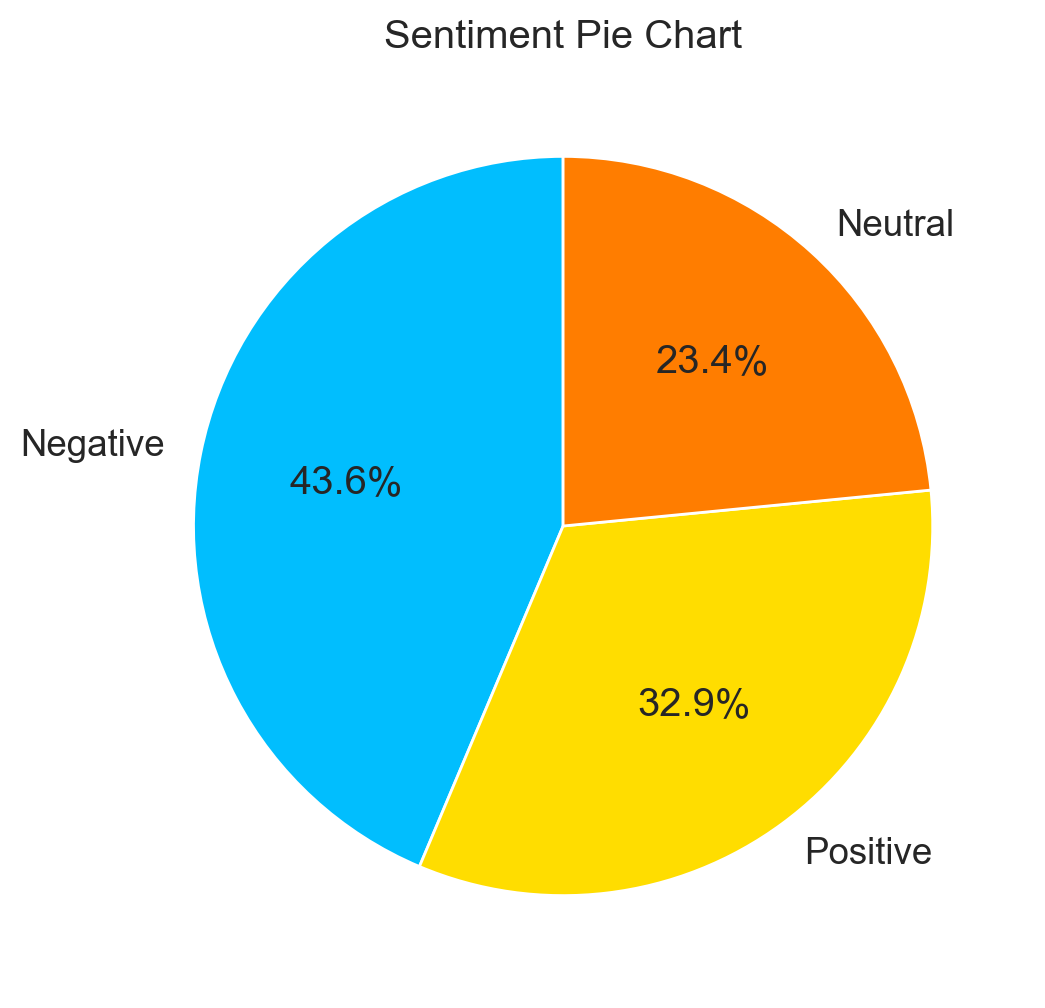

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df = relevant_data

sentiment_counts = df['Sentiment_Label'].value_counts()
plt.figure(figsize=(8, 6))
sentiment_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Pie Chart')
plt.ylabel('')
plt.show()


In [ ]:
# training a XLNet on telling whether an event is in favor of Palestine or Israel or Neutral.

ps = pd.read_csv('post_stance.csv')
ps.head()

,post,favors
0,IDF on shooting from Yemen: 'Iran-backed milit...,Israel
1,Israel agrees to allow 100 trucks of humanitar...,Palestine
2,Israel restored Gaza's internet under U.S. pre...,Neutral
3,U.S. asked Israel to release withheld Palestin...,Palestine
4,Israeli Govt. Denies Rolling Stone a Press Cre...,Israel


In [ ]:
from sklearn.utils import shuffle
ps = shuffle(ps)
ps.head(20)

,post,favors
65,"After Years of Vowing to Destroy Israel, Iran ...",Neutral
54,Hamas armed wing says it discussed freeing 70 ...,Palestine
7,Hamas official promises: 'We'll repeat Oct. 7 ...,Palestine
72,"30 years after illegal takeover, High Court or...",Palestine
71,Palestinian American family mourns 42 relative...,Palestine
66,Gaza border opened to allow some badly wounded...,Palestine
4,Israeli Govt. Denies Rolling Stone a Press Cre...,Israel
18,Hamas says will allow foreigners to leave Gaza,Neutral
62,Exposed: How Hamas steals fuel from Gaza's hos...,Israel
68,IDF releases proof of Hamas stealing gas from ...,Israel


In [ ]:
def stance2label(stance):
    if stance == "Palestine":
        return 2
    elif stance == "Neutral":
        return 1
    else:
        return 0

ps['favors'] = ps['favors'].apply(stance2label)

In [ ]:
ps['favors'].value_counts()

0    39
1    33
2    33
Name: favors, dtype: int64

In [ ]:
class_names = ['Israel', 'Neutral', 'Palestine']

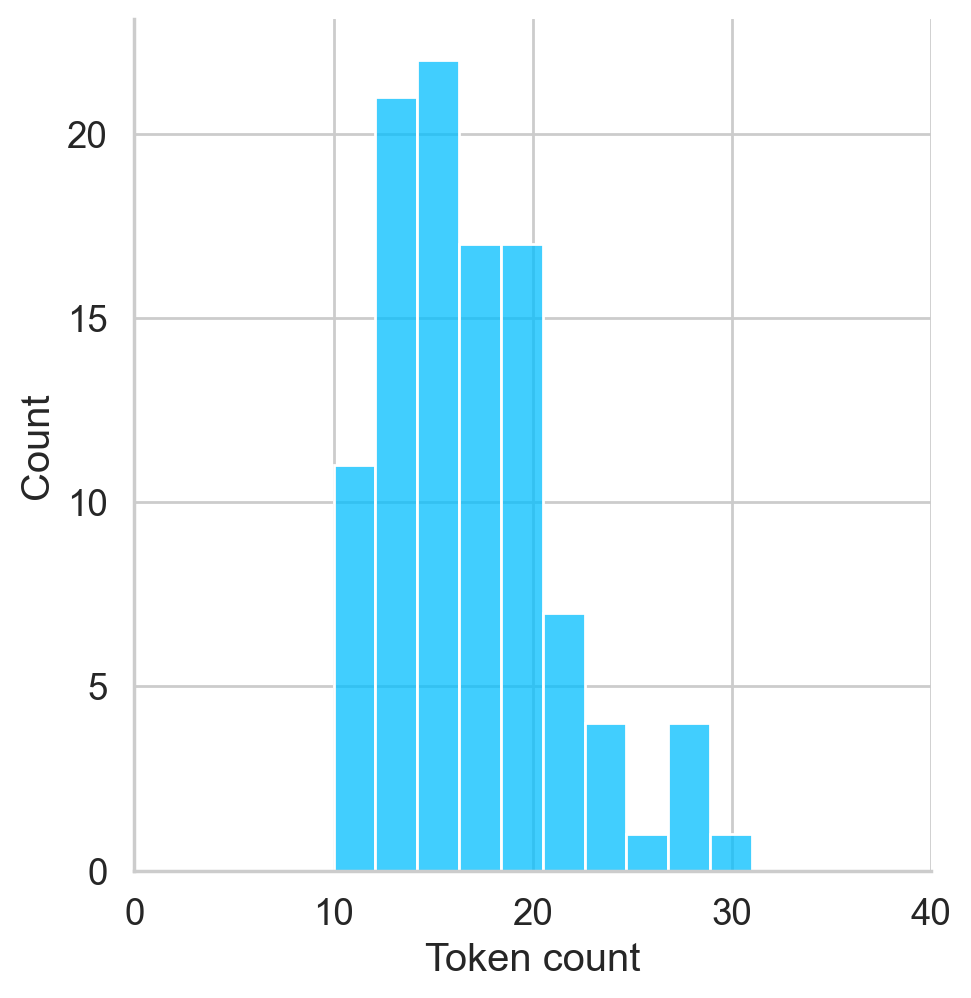

In [ ]:
from transformers import XLNetTokenizer, XLNetModel
PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


# token length distribution

token_lens = []

for txt in ps['post']:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

sns.displot(token_lens)
plt.xlim([0, 40]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 40
BATCH_SIZE = 4

In [ ]:
from transformers import PreTrainedTokenizer

class PostDataset(Dataset):

    def __init__(self, reports, targets, tokenizer: PreTrainedTokenizer, max_len):
        self.reports = reports
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reports)

    def __getitem__(self, item):
        report = str(self.reports[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            report,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',  # Enable padding
            return_attention_mask=True,
            return_tensors='pt',  # Returns PyTorch tensors
        )

        # No need for extra pad_sequences or tensor conversion
        input_ids = encoding['input_ids'].squeeze()  # Remove extra dimension
        attention_mask = encoding['attention_mask'].squeeze()

        return {
            'post_text': report,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'targets': torch.tensor(target, dtype=torch.long)
        }


In [ ]:
ps_train, ps_test = train_test_split(ps, test_size=0.5, random_state=101)
ps_val, ps_test = train_test_split(ps_test, test_size=0.5, random_state=101)

In [ ]:
ps_train.shape, ps_val.shape, ps_test.shape

((52, 2), (26, 2), (27, 2))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = PostDataset(
    reports=ps['post'].to_numpy(),
    targets=ps['favors'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=0,
    shuffle=True,
    drop_last=True
  )

In [ ]:
train_data_loader = create_data_loader(ps_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(ps_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(ps_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
from transformers import XLNetForSequenceClassification
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels = 3)
model = model.to(device)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
model

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

In [ ]:
EPOCHS = 10

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

/Users/zs_jin/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
data = next(iter(val_data_loader))
data.keys()

dict_keys(['post_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
targets = data['targets'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([4, 40])
torch.Size([4, 40])


# Training and evaluation

In [ ]:

from sklearn import metrics
def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    acc = 0
    counter = 0

    for d in data_loader:
        input_ids = d["input_ids"].reshape(4,MAX_LEN).to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
        loss = outputs[0]
        logits = outputs[1]

        # preds = preds.cpu().detach().numpy()
        _, prediction = torch.max(outputs[1], dim=1)
        targets = targets.cpu().detach().numpy()
        prediction = prediction.cpu().detach().numpy()
        accuracy = metrics.accuracy_score(targets, prediction)

        acc += accuracy
        losses.append(loss.item())

        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        counter = counter + 1

    return acc / counter, np.mean(losses)

def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    acc = 0
    counter = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].reshape(4,MAX_LEN).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
            loss = outputs[0]
            logits = outputs[1]

            _, prediction = torch.max(outputs[1], dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(targets, prediction)

            acc += accuracy
            losses.append(loss.item())
            counter += 1

    return acc / counter, np.mean(losses)


In [ ]:
def check_batch_shape(dataloader):
    for i, batch in enumerate(dataloader):
        if batch['input_ids'].shape != (4, 40):
            print(f"Batch {i} has incorrect shape: {batch['input_ids'].shape}")
        else:
            print(f"Batch {i} is correctly shaped.")

check_batch_shape(train_data_loader)

Batch 0 is correctly shaped.
Batch 1 is correctly shaped.
Batch 2 is correctly shaped.
Batch 3 is correctly shaped.
Batch 4 is correctly shaped.
Batch 5 is correctly shaped.
Batch 6 is correctly shaped.
Batch 7 is correctly shaped.
Batch 8 is correctly shaped.
Batch 9 is correctly shaped.
Batch 10 is correctly shaped.
Batch 11 is correctly shaped.
Batch 12 is correctly shaped.
Batch 13 is correctly shaped.
Batch 14 is correctly shaped.
Batch 15 is correctly shaped.
Batch 16 is correctly shaped.
Batch 17 is correctly shaped.
Batch 18 is correctly shaped.
Batch 19 is correctly shaped.
Batch 20 is correctly shaped.
Batch 21 is correctly shaped.
Batch 22 is correctly shaped.
Batch 23 is correctly shaped.
Batch 24 is correctly shaped.
Batch 25 is correctly shaped.


# Training

Epoch 1/10
----------
Train loss 1.1388721282665546 Train accuracy 0.34615384615384615
Val loss 1.0933756759533515 Val accuracy 0.34615384615384615

Epoch 2/10
----------
Train loss 1.0953483031346247 Train accuracy 0.47115384615384615
Val loss 1.1079340531275823 Val accuracy 0.5865384615384616

Epoch 3/10
----------
Train loss 1.0723367998233209 Train accuracy 0.38461538461538464
Val loss 0.8967456359129685 Val accuracy 0.5961538461538461

Epoch 4/10
----------
Train loss 1.0397217869758606 Train accuracy 0.5192307692307693
Val loss 0.906094491481781 Val accuracy 0.6346153846153846

Epoch 5/10
----------
Train loss 0.9166543139861181 Train accuracy 0.5480769230769231
Val loss 0.7840481480726829 Val accuracy 0.6826923076923077

Epoch 6/10
----------
Train loss 0.7711335340371499 Train accuracy 0.7019230769230769
Val loss 0.4874690662209804 Val accuracy 0.8365384615384616

Epoch 7/10
----------
Train loss 0.6406414336883105 Train accuracy 0.75
Val loss 0.37101372617941636 Val accuracy 0

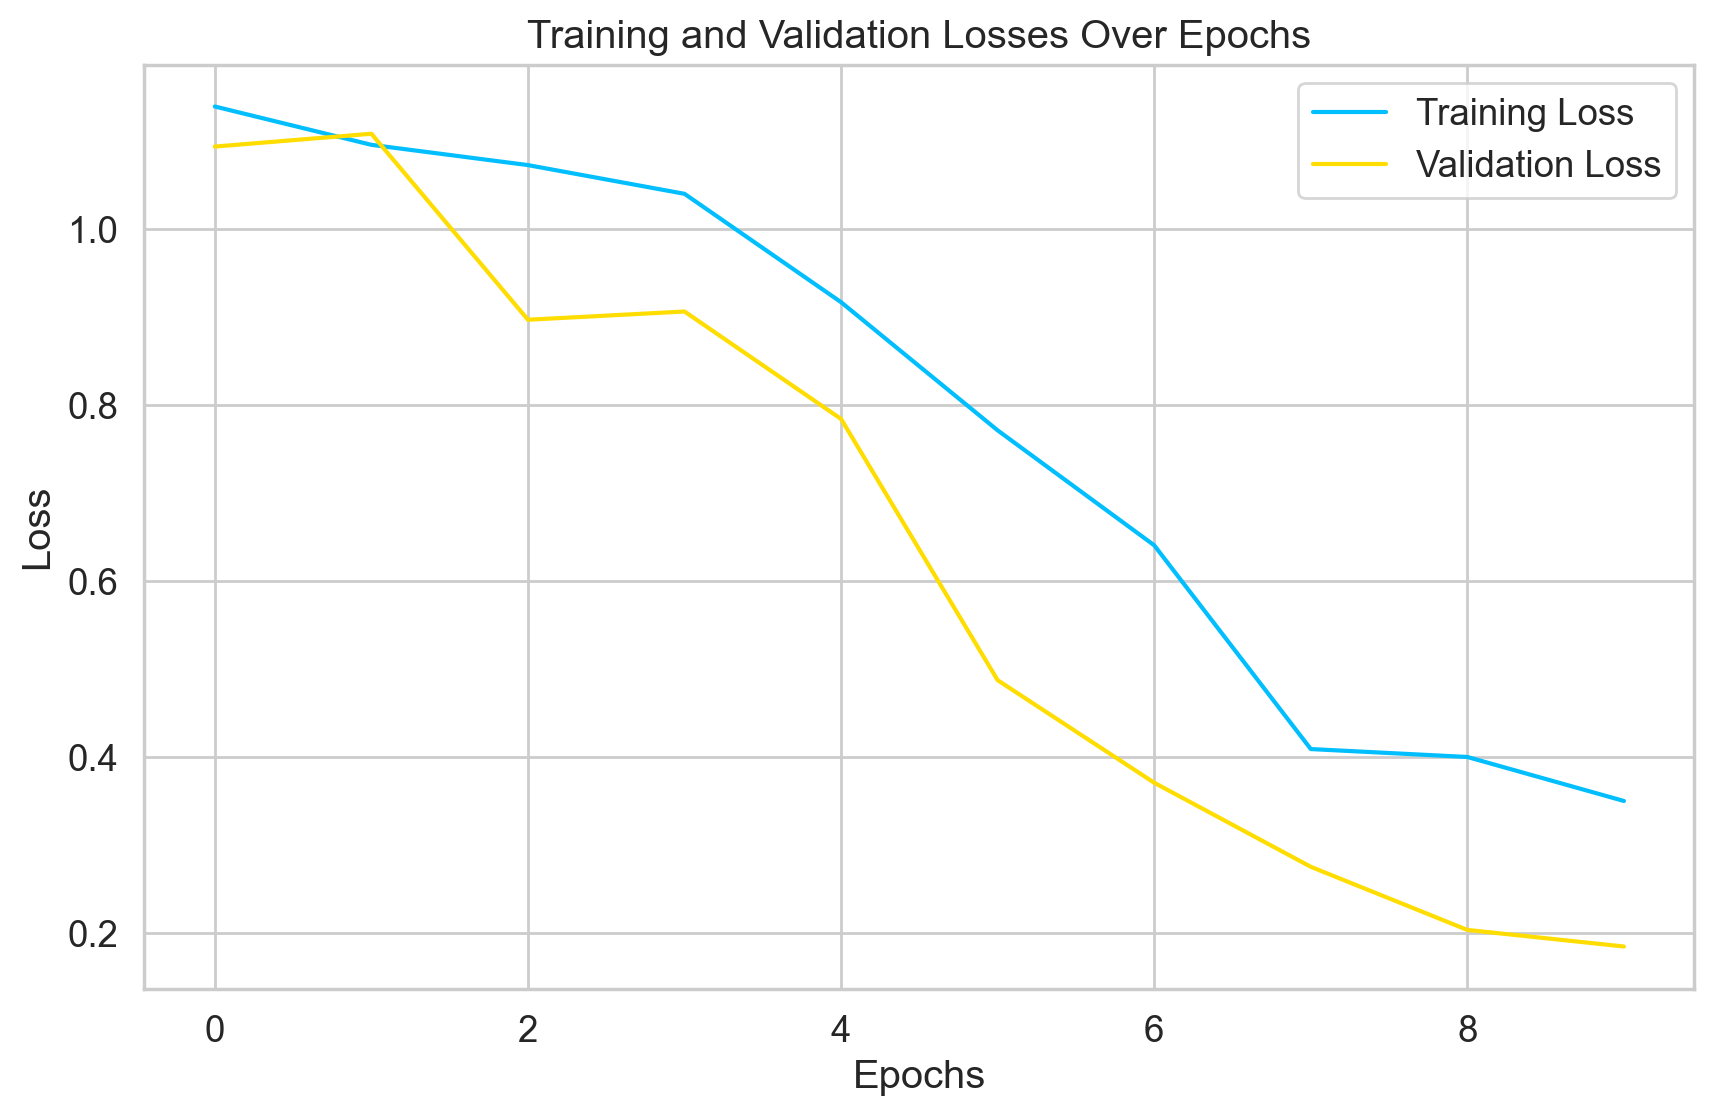

CPU times: user 9min 53s, sys: 9min 36s, total: 19min 30s
Wall time: 2min 12s


In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        optimizer,
        device,
        scheduler,
        len(ps_train)
    )

    print(f'Train loss {train_loss} Train accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        device,
        len(ps_val)
    )

    print(f'Val loss {val_loss} Val accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'xlnet_model.bin')
        best_accuracy = val_acc


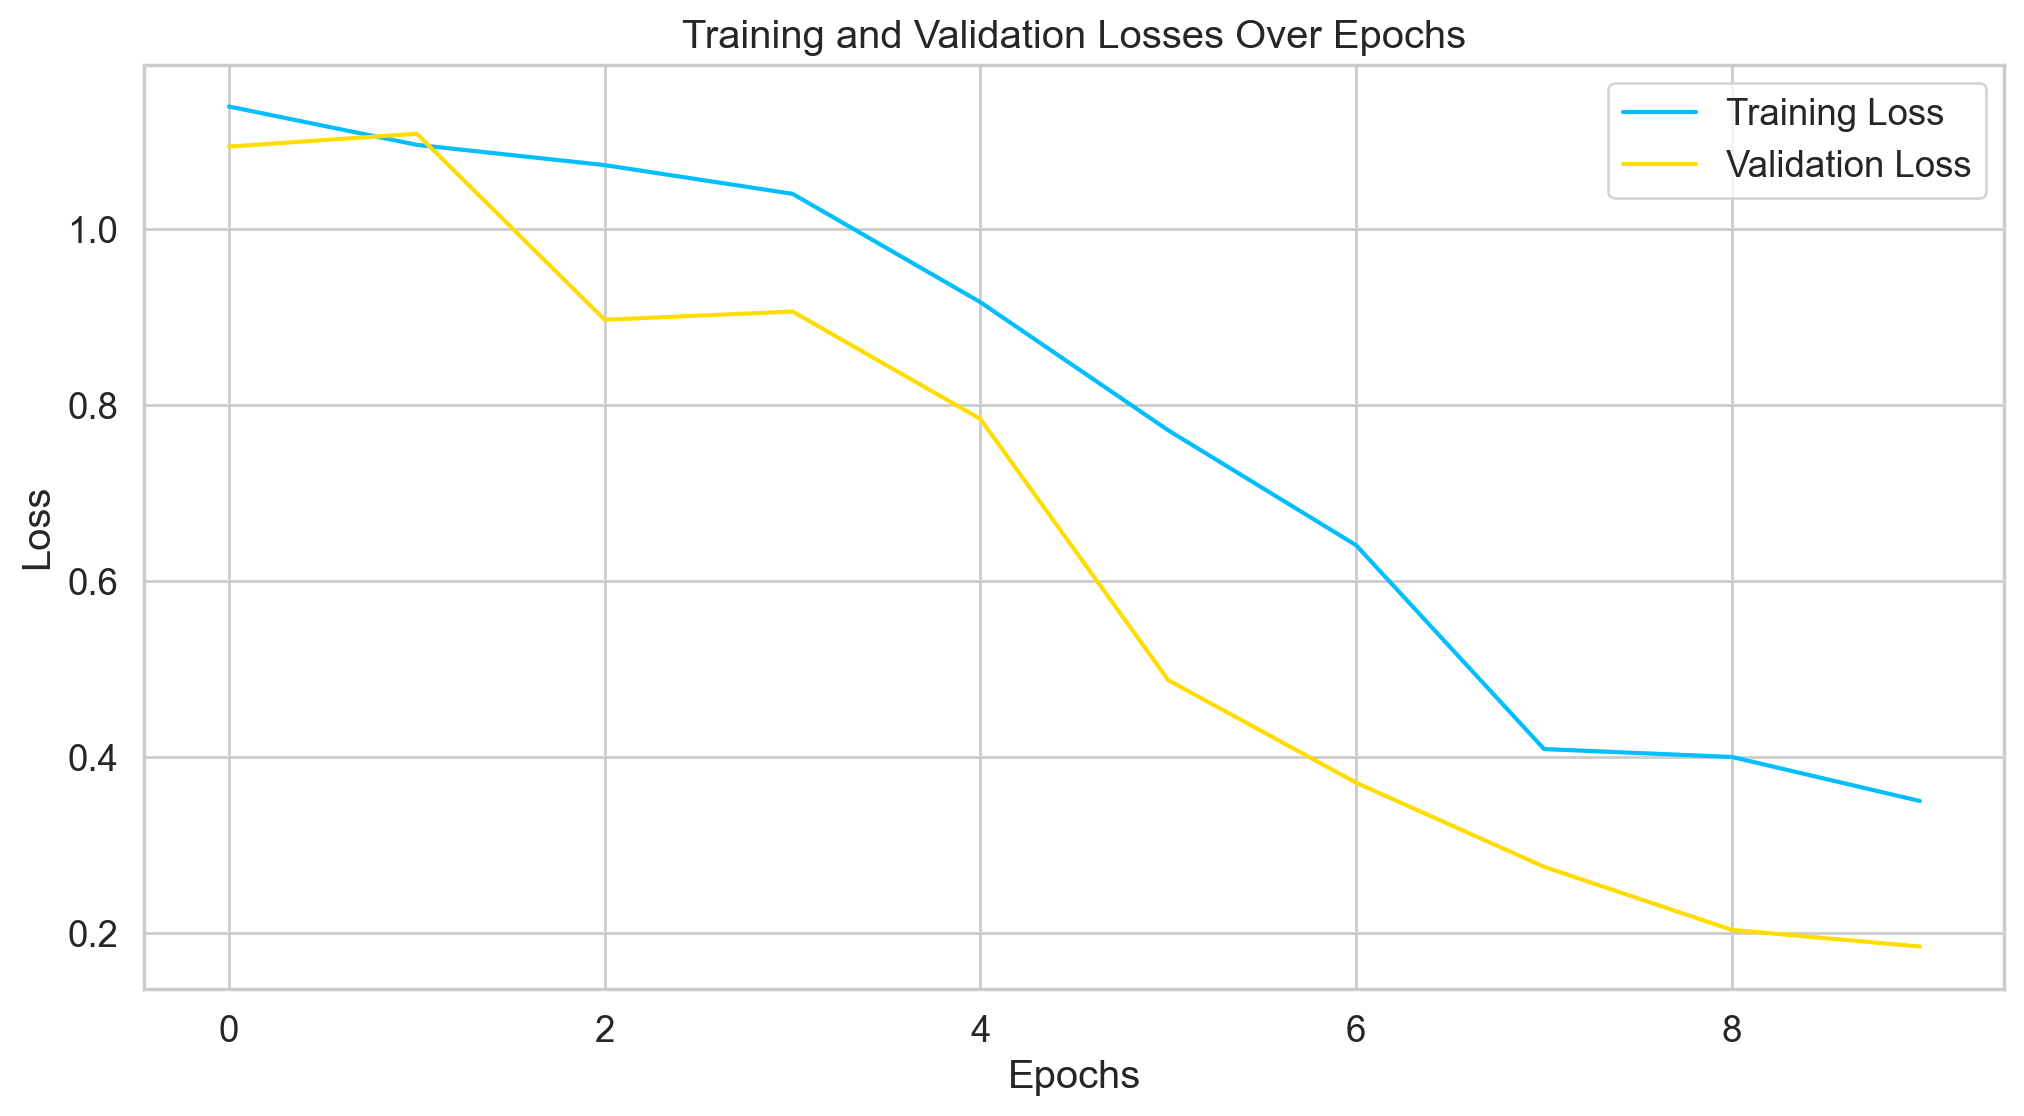

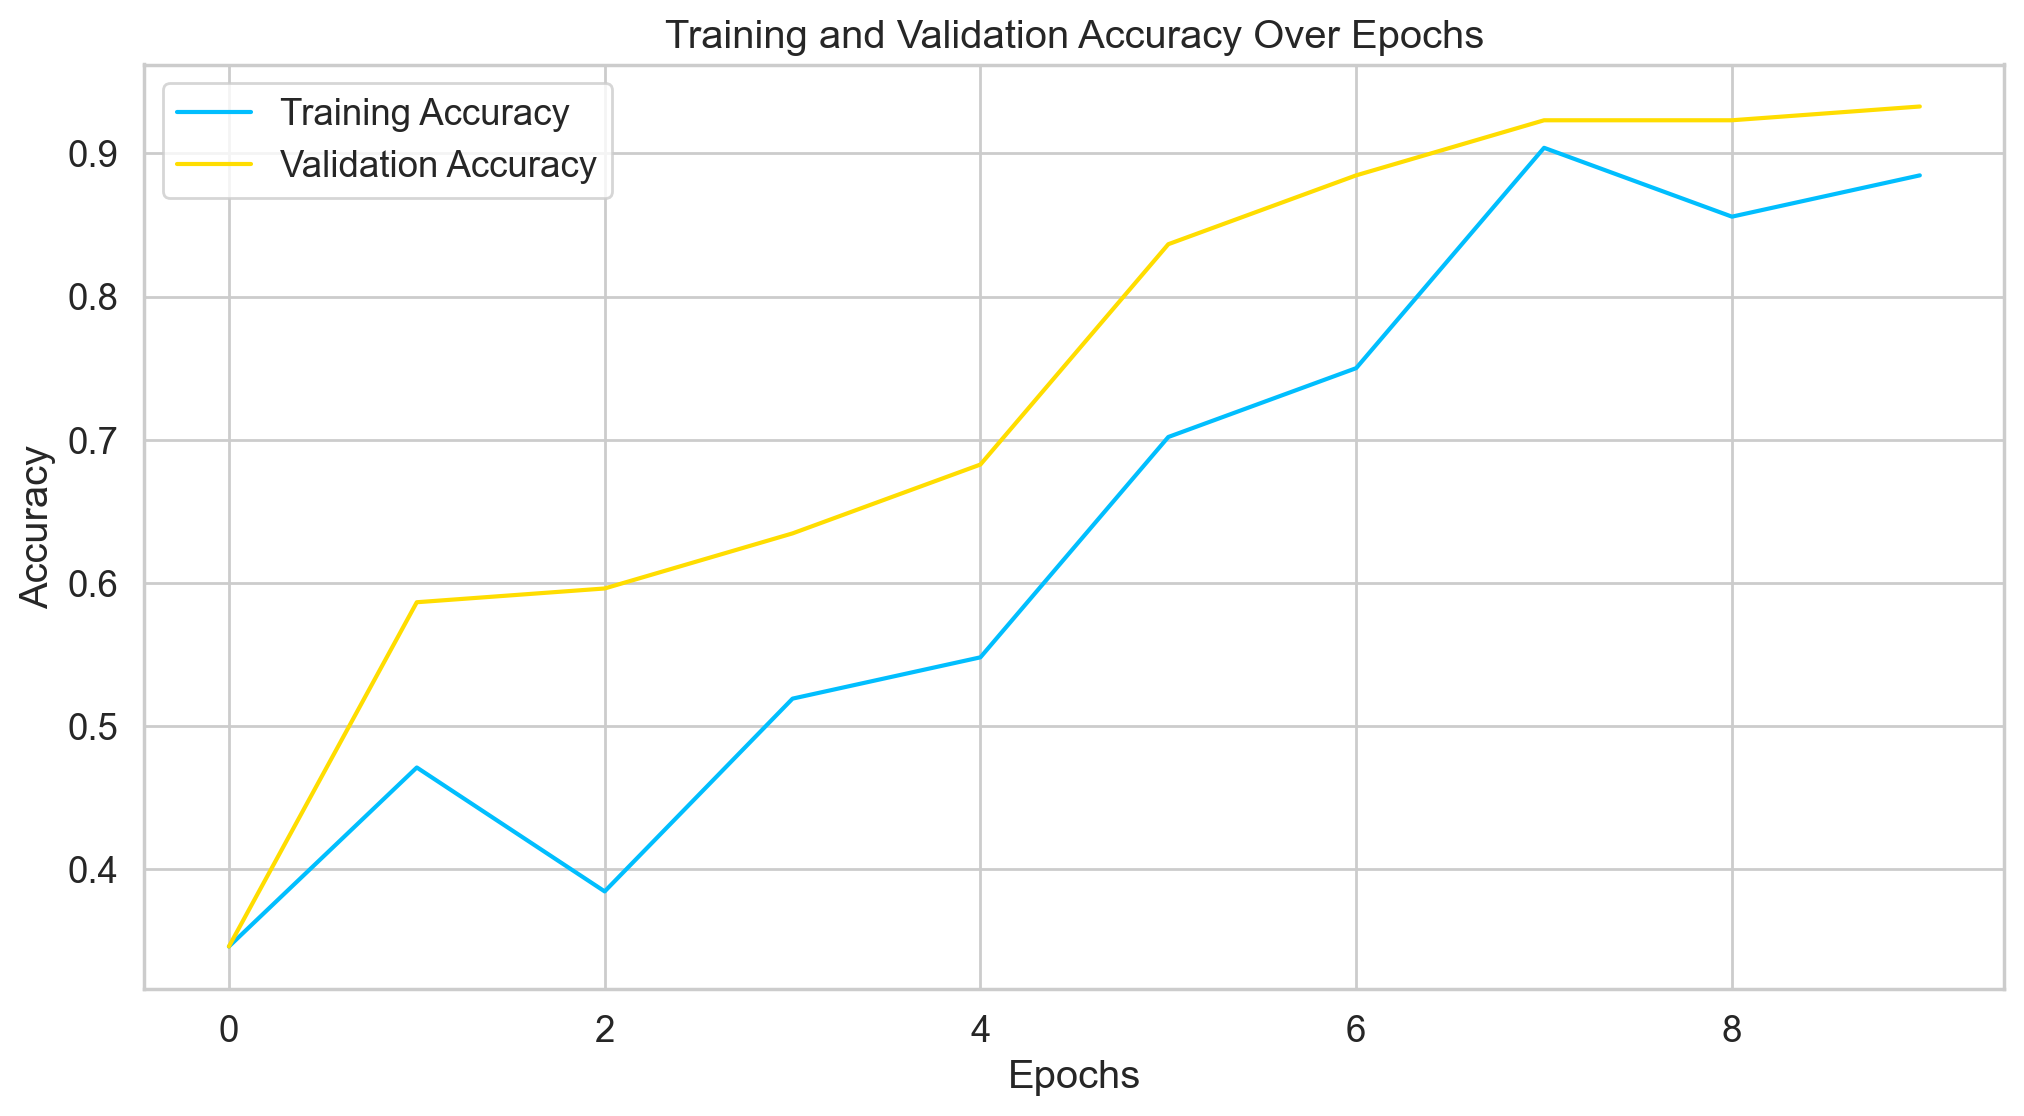

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')

plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

# evaluating the model

In [ ]:
model.load_state_dict(torch.load('xlnet_model.bin'))

<All keys matched successfully>

In [ ]:
model = model.to(device)

In [ ]:
test_acc, test_loss = eval_model(
  model,
  test_data_loader,
  device,
  len(ps_test)
)

print('Test Accuracy :', test_acc)
print('Test Loss :', test_loss)

Test Accuracy : 0.9326923076923077
Test Loss : 0.1852585240625418


In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    post_titles = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["post_text"]
            input_ids = d["input_ids"].reshape(4,MAX_LEN).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)

            loss = outputs[0]
            logits = outputs[1]

            _, preds = torch.max(outputs[1], dim=1)

            probs = F.softmax(outputs[1], dim=1)

            post_titles.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return post_titles, predictions, prediction_probs, real_values

In [ ]:
y_post_titles, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      Israel       0.93      1.00      0.96        39
     Neutral       0.91      0.97      0.94        33
   Palestine       1.00      0.84      0.92        32

    accuracy                           0.94       104
   macro avg       0.95      0.94      0.94       104
weighted avg       0.95      0.94      0.94       104



# Raw text to stance using trained model

In [ ]:
def predict_stance(text):
    post_title = text

    encoded_title = tokenizer.encode_plus(
    post_title,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt',
    )

    input_ids = pad_sequences(encoded_title['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    input_ids = input_ids.astype(dtype = 'int64')
    input_ids = torch.tensor(input_ids)

    attention_mask = pad_sequences(encoded_title['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    attention_mask = attention_mask.astype(dtype = 'int64')
    attention_mask = torch.tensor(attention_mask)

    input_ids = input_ids.reshape(1,MAX_LEN).to(device)
    attention_mask = attention_mask.to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs[0]
    probs = F.softmax(logits, dim=-1).cpu().numpy()[0]
    prediction = torch.argmax(logits, dim=-1).cpu().numpy()[0]

    """
    print(f"Review text: {text}")
    for i, class_name in enumerate(class_names):
        print(f"{class_name} score: {probs[i]:.4f}")
    print(f"Predicted class: {class_names[prediction]}")
    """

    return int(prediction)

In [ ]:
# example
title = "The fate of many Gazans lies with the Rafah crossing, and Egypt."
print(predict_stance(title))

1


Now that we have a trained model that can tell us what the event in the title is in favor of, we can collect results from the title of each post.

In [ ]:
df['is_first_occurrence'] = ~df.duplicated(subset='Cleaned_Title')


for index, row in df[df['is_first_occurrence']].iterrows():
    prediction = predict_stance(row['Cleaned_Title'])  # Replace with your actual prediction call
    df.at[index, 'Event_Benefactive'] = prediction

df.loc[~df['is_first_occurrence'], 'Event_Benefactive'] = None

df.drop(columns=['is_first_occurrence'], inplace=True)

In [ ]:
print(df.head())

                                               Title  \
0  Exposed: How Hamas steals fuel from Gaza's hos...   
1                                            Comment   
2                                            Comment   
3                                            Comment   
4                                            Comment   

                                                Text           Timestamp  \
0  Exposed: How Hamas steals fuel from Gaza's hos... 2023-11-01 15:33:37   
1  When the entirety of infrastructure in Gaza, h... 2023-11-01 15:38:45   
2            No, silly, Israelis are the monsters... 2023-11-01 15:46:02   
3  People truly do not understand how sick Hamas ... 2023-11-01 15:45:27   
4                              Oh shit wrong sub huh 2023-11-01 15:46:43   

            Author  Upvotes  Number of Comments  \
0    everybodydumb       20                   5   
1     Hk-Neowizard        1                   0   
2  StrangerFew2424        1                   0   
3 

In [ ]:
def sentiment_to_numeric(label):
    mapping = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
    return mapping.get(label, 0)

current_post_sentiment = 0
start_of_post_index = None
for index, row in df.iterrows():
    if pd.notna(row['Event_Benefactive']):
        if start_of_post_index is not None:
            df.at[start_of_post_index, 'General_Sentiment'] = current_post_sentiment
        start_of_post_index = index
        current_post_sentiment = 0

    current_post_sentiment += sentiment_to_numeric(row['Sentiment_Label']) * row['Upvotes']

# Handle the last post
if start_of_post_index is not None:
    df.at[start_of_post_index, 'General_Sentiment'] = current_post_sentiment

# Optionally, fill NaN values in 'General_Sentiment' with a default value (e.g., 0)
df['General_Sentiment'].fillna(8, inplace=True)

In [ ]:
for index, row in df.iterrows():
    if row['General_Sentiment'] != 8:
        print(f"post_title:{row['Cleaned_Title']}, sentiment:{row['General_Sentiment']}")

post_title:exposed hamas steals fuel gaza hospitals, sentiment:0.0
post_title:uae official abraham accords stay vinnews, sentiment:2.0
post_title:clashes erupt 9th day protests controversial copper mine contract panama efe noticias, sentiment:-12.0
post_title:germany minister casts doubt 2030 coal exit, sentiment:-3.0
post_title:germany plans easing asylum seekers access labor market, sentiment:0.0
post_title:companies india likely give 9 8 salary raise 2024 highest apac report, sentiment:0.0
post_title:state department struggles explain american citizens still exit gaza, sentiment:-1.0
post_title:cyprus plans send humanitarian aid directly gaza ship un personnel would receive, sentiment:4.0
post_title:gaza border opened allow badly wounded foreign passport holders flee war, sentiment:-12.0
post_title:israeli envoy russia says tel aviv passengers hid weekend airport riot terminal, sentiment:-38.0
post_title:idf releases proof hamas stealing gas gazan hospitals, sentiment:-534.0
post_ti

# visualization of the general sentiment w.r.t the benefactive of the post event.

/var/folders/0v/5332h4d15q7cn_5xwjtkv2840000gn/T/ipykernel_23634/758472798.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  palestine_df['Capped_Sentiment'] = cap_values(palestine_df['General_Sentiment'], cap_value)
/var/folders/0v/5332h4d15q7cn_5xwjtkv2840000gn/T/ipykernel_23634/758472798.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  israel_df['Capped_Sentiment'] = cap_values(israel_df['General_Sentiment'], cap_value)
/var/folders/0v/5332h4d15q7cn_5xwjtkv2840000gn/T/ipykernel_23634/758472798.py:

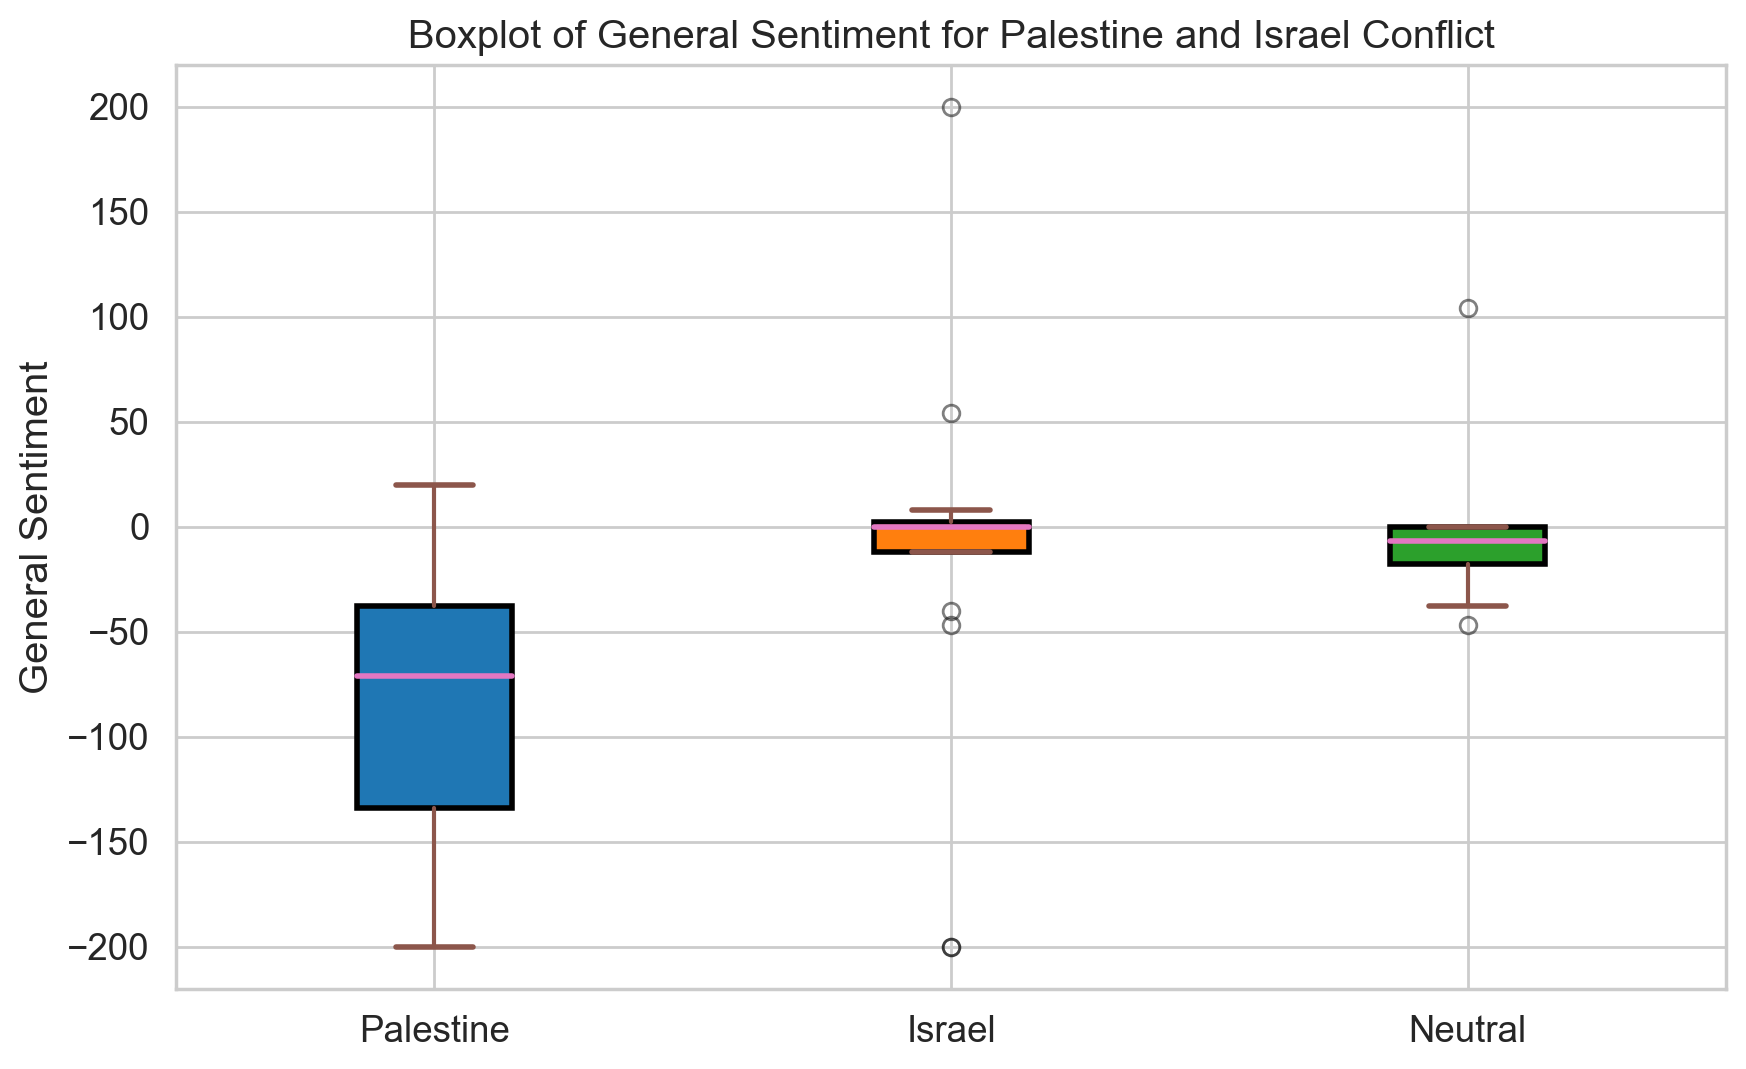

In [ ]:
filtered_df = df[pd.notna(df['Event_Benefactive'])]

# Separate the data into different categories
palestine_df = filtered_df[filtered_df['Event_Benefactive'] == 2]
neutral_df = filtered_df[filtered_df['Event_Benefactive'] == 1]
israel_df = filtered_df[filtered_df['Event_Benefactive'] == 0]

def cap_values(series, cap):
    return series.clip(lower=-cap, upper=cap)

cap_value = 200  # Set this based on your data analysis
palestine_df['Capped_Sentiment'] = cap_values(palestine_df['General_Sentiment'], cap_value)
israel_df['Capped_Sentiment'] = cap_values(israel_df['General_Sentiment'], cap_value)
neutral_df['Capped_Sentiment'] = cap_values(neutral_df['General_Sentiment'], cap_value)

# Plot with the capped values


import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn for better aesthetics
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))

# Data to plot
data_to_plot = [
    palestine_df['Capped_Sentiment'],
    israel_df['Capped_Sentiment'],
    neutral_df['Capped_Sentiment']
]

# Creating the boxplot with custom colors and styles
box = plt.boxplot(data_to_plot, patch_artist=True, labels=['Palestine', 'Israel', 'Neutral'])

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Custom colors for the boxes
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_linewidth(2)

# Customizing the whiskers, caps, and medians
for whisker in box['whiskers']:
    whisker.set(color='#8c564b', linewidth=1.5)

for cap in box['caps']:
    cap.set(color='#8c564b', linewidth=2)

for median in box['medians']:
    median.set(color='#e377c2', linewidth=2)

# Customizing the fliers (outliers)
for flier in box['fliers']:
    flier.set(marker='o', color='#7f7f7f', alpha=0.5)

plt.ylabel('General Sentiment')
plt.title('Boxplot of General Sentiment for Palestine and Israel Conflict')

plt.show()
